## Quantum circuit for an exponential of pauli strings

For SUSY QM, the Hamiltonian, $H$ can be qubitized, which results in the Hamiltonian being written as a sum of terms, with each term containing a produce of pauli matrices acting on the qubits.  Given some initial state, we can apply the time evolution operator, 
\begin{equation}
    e^{iHt}.
\end{equation}
To realize this on a quantum computer, we use the Suzuki-Trotter formula
\begin{equation}
    e^{i\sum_j H_j t}=\prod_j e^{i H_j \delta t} + \mathcal{O}()
\end{equation}
Since qubitizing the Hamiltonian results in an expression for $H$ in terms of pauli operators, we need to be able to write down the quantum circuit for an exponential of pauli matrices.  This is accomplished with the so-called "ladder" circuit, which we now detail.

First we go through some example cases showing that the exponential of the Hamiltonian is a quantum circuit.

In [1]:
import numpy as np #we will use numpy's kron function for tensor products, and its matmul for matrix multiplication.

#definition of the identity, pauli X and Z matrices, and the two-qubit CNOT matrix.
ID=np.array([[1,0],[0,1]])
X=np.array([[0,1],[1,0]])
Z=np.array([[1,0],[0,-1]])
CNOT=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [2]:
#A quick check that we are doing kronecker products correctly
#The CNOT gate is the identity, if the control qubit is zero, and a NOT(X) gate otherwise
assert(CNOT.all() == (np.kron([[1,0],[0,0]],ID) + np.kron([[0,0],[0,1]],X)).all())

In [3]:
#To avoid using an algebraic library, like sci-py, I pick specific values for cos(t) and i sin(t)...
#cos(t) = A 
#i sin(t) = B
A=0.2
B=0.3
RZ=A*ID + B*Z #a rotation around the z-axis with given values for t (that don't make sense)

Now we can check that the circuit for 
\begin{equation}
    e^{-i(Z \otimes Z)t} = \text{CNOT}\times(\mathcal{1}\otimes R_z)\times \text{CNOT}
\end{equation}

In [4]:
LHS=A*np.kron(ID,ID) + B*np.kron(Z,Z)
RHS=np.matmul(CNOT,np.matmul(np.kron(ID,RZ),CNOT))

#print(LHS)
#print(RHS)
assert(LHS.all()==RHS.all())

In [5]:
#We now repeat this for a pauli Z applied to 3 qubits.
LHS = A*np.kron(ID,np.kron(ID,ID)) + B*np.kron(Z,np.kron(Z,Z))

CNOT1=np.kron(CNOT,ID)
CNOT2=np.kron(ID,CNOT)
RZ3=np.kron(ID,np.kron(ID,RZ))

RHS=np.matmul(CNOT1,np.matmul(CNOT2,np.matmul(RZ3,np.matmul(CNOT2,CNOT1))))

assert(LHS.all()==RHS.all())

QISKIT already contains a method for implementing Trotterization to a exponential written as a sum of pauli matrices.

In [6]:
from qiskit.aqua.operators import I,X,Y,Z, PauliTrotterEvolution
from qiskit import QuantumCircuit, transpile

e^(-i*ZZ)
     ┌───┐┌───┐┌───┐┌───────┐┌───┐┌───┐┌───┐
q_0: ┤ I ├┤ X ├┤ I ├┤ RZ(2) ├┤ I ├┤ X ├┤ I ├
     ├───┤└─┬─┘├───┤└───────┘└───┘└─┬─┘├───┤
q_1: ┤ I ├──■──┤ I ├────────────────■──┤ I ├
     └───┘     └───┘                   └───┘


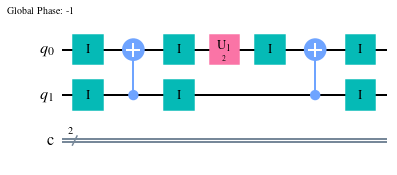

In [10]:
operator = ((Z^Z).exp_i())
trotter_op = PauliTrotterEvolution(trotter_mode='suzuki').convert(operator)
print(operator)
print(trotter_op)
qc = QuantumCircuit(2,2)
qc.append(trotter_op, [0,1])
transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z','id']).draw('mpl')

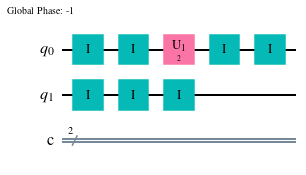

In [8]:
transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z', 'id'],optimization_level=3).draw('mpl')

e^(-i*XZ)
     ┌───┐┌───┐┌───┐┌───┐┌───────┐┌───┐┌───┐┌───┐┌───┐
q_0: ┤ I ├┤ I ├┤ X ├┤ I ├┤ RZ(2) ├┤ I ├┤ X ├┤ I ├┤ I ├
     ├───┤├───┤└─┬─┘├───┤└───────┘└───┘└─┬─┘├───┤├───┤
q_1: ┤ I ├┤ H ├──■──┤ I ├────────────────■──┤ H ├┤ I ├
     └───┘└───┘     └───┘                   └───┘└───┘


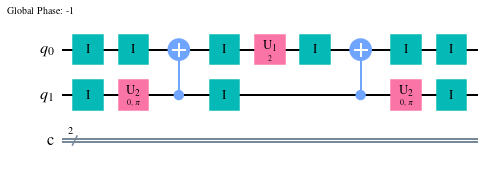

In [9]:
operator = ((X^Z).exp_i())
trotter_op = PauliTrotterEvolution(trotter_mode='suzuki').convert(operator)
print(operator)
print(trotter_op)
qc = QuantumCircuit(2,2)
qc.append(trotter_op, [0,1])
transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z', 'id']).draw('mpl')

e^(-i*XYZ)
      ┌───┐ ┌───┐┌───┐┌───┐┌───┐┌───────┐┌───┐┌───┐┌───┐┌───┐┌───┐
q_0: ─┤ I ├─┤ I ├┤ X ├┤ X ├┤ I ├┤ RZ(2) ├┤ I ├┤ X ├┤ X ├┤ I ├┤ I ├
     ┌┴───┴┐├───┤└─┬─┘└─┬─┘├───┤└───────┘└───┘└─┬─┘└─┬─┘├───┤├───┤
q_1: ┤ SDG ├┤ H ├──■────┼──┤ I ├────────────────┼────■──┤ H ├┤ S ├
     └┬───┬┘├───┤       │  ├───┤                │  ┌───┐├───┤└───┘
q_2: ─┤ I ├─┤ H ├───────■──┤ I ├────────────────■──┤ H ├┤ I ├─────
      └───┘ └───┘          └───┘                   └───┘└───┘     


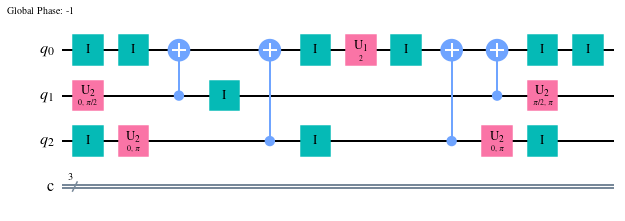

In [16]:
operator = ((X^Y^Z).exp_i())
trotter_op = PauliTrotterEvolution(trotter_mode='suzuki').convert(operator)
print(operator)
print(trotter_op)
qc = QuantumCircuit(3,3)
qc.append(trotter_op, [0,1,2])#
#qc.draw('mpl')
transpile(qc, basis_gates = ['cx', 'u1', 'u2', 'u3', 'H', 'X', 'Y', 'Z', 'id']).draw('mpl')

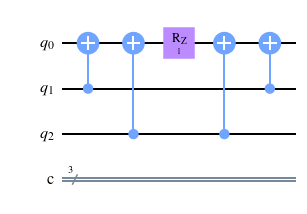

In [26]:
qc2=QuantumCircuit(3,3)
qc2.cx(1,0)
qc2.cx(2,0)
qc2.rz(1,0)
qc2.cx(2,0)
qc2.cx(1,0)
qc2.draw('mpl',filename='PLOTS/ladder_circuit.png')